## Compare HDF5 and Feather performance for storing and reading columnar float data

Let's create a set of increasingly large 2-column pandas dataframes, with numbers of rows $N = 2^n,\, n \in [8,25]$. For each number of rows, we measure the time used by `.to_hdf()` and `.to_feather()`, evaluate the size of the resulting file, and measure the time used by `.read_hdf()` and `.read_feather()`

In [13]:
import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [14]:
pd.__version__

'1.3.5'

In [15]:
import pyarrow
pyarrow.__version__

'6.0.1'

In [16]:
rows = []
stats = dict()
stats['storing_times'] = dict()
stats['reading_times'] = dict()
stats['sizes'] = dict()
stats['storing_times']['HDF'] = dict()
stats['reading_times']['HDF'] = dict()
stats['sizes']['HDF'] = dict()
stats['storing_times']['Feather'] = dict()
stats['reading_times']['Feather'] = dict()
stats['sizes']['Feather'] = dict()
for n in range(8,24):
    n_rows = 2**n
    n_columns_per_type = 2
    rows.append(n_rows)
    data_integers = pd.DataFrame(np.random.randint(0, 64000000, size=(n_rows,n_columns_per_type)))
    data_floats = pd.DataFrame(np.random.random_sample(size=(n_rows,n_columns_per_type))*64000000)
    data_strings = pd.DataFrame(pd.util.testing.rands_array(10, size=(n_rows,n_columns_per_type)))
    large = pd.concat((data_integers, data_floats, data_strings), axis=1)
    large.columns = ['c' + str(pos) for pos in range(len(large.columns))]
    hdf_storing_time = %timeit -q -n1 -o large.to_hdf('test_hdf_'+ str(n_rows) + '.hdf',key='hdf', complib="blosc:lz4", complevel=5,  mode="w", format="fixed")
    stats['storing_times']['HDF'][n_rows] = hdf_storing_time.best
    feather_storing_time = %timeit -q -n1 -o large.to_feather('test_feather_' + str(n_rows) + '.fth')
    stats['storing_times']['Feather'][n_rows] = feather_storing_time.best
    
    hdf_size = os.stat('test_hdf_'+ str(n_rows) + '.hdf').st_size/1024/1024
    stats['sizes']['HDF'][n_rows] = hdf_size
    feather_size = os.stat('test_feather_' + str(n_rows) + '.fth').st_size/1024/1024
    stats['sizes']['Feather'][n_rows] = feather_size
    
    hdf_reading_time = %timeit -q -n1 -o large_read = pd.read_hdf('test_hdf_'+ str(n_rows) + '.hdf',key='hdf')
    stats['reading_times']['HDF'][n_rows] = hdf_reading_time.best
    feather_reading_time = %timeit -q -n1 -o large_read = pd.read_feather('test_feather_' + str(n_rows) + '.fth')
    stats['reading_times']['Feather'][n_rows] = feather_reading_time.best

In [18]:
dic = {'storing_times' : pd.DataFrame(stats['storing_times']), 'sizes' : pd.DataFrame(stats['sizes']), 'reading_times' : pd.DataFrame(stats['reading_times'])}
res = pd.concat(dic.values(),axis=1,keys=dic.keys())

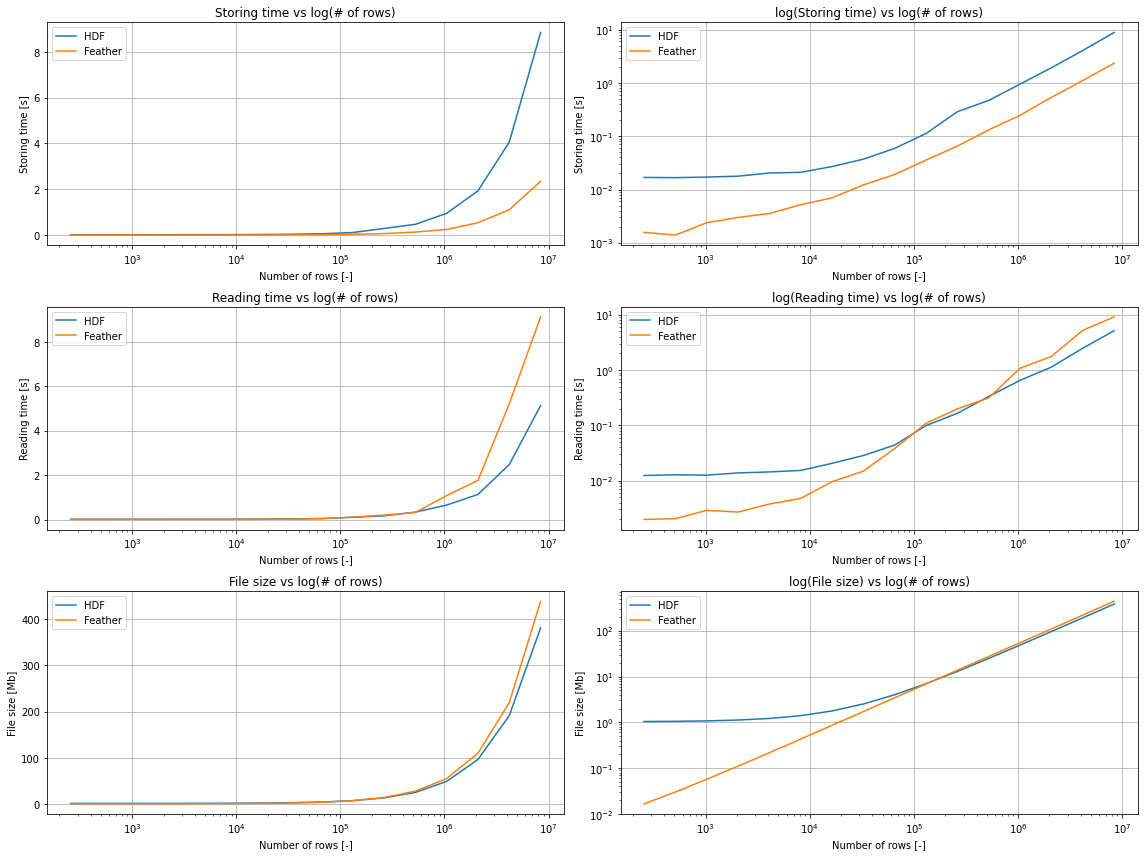

In [19]:
fig, ax = plt.subplots(3,2, figsize=(16,12))

# Storing times
res['storing_times'].plot(ax=ax[0][0])
ax[0][0].set_xticks(rows)
ax[0][0].set_xscale("log")
ax[0][0].set_xlabel('Number of rows [-]')
ax[0][0].set_ylabel('Storing time [s]')
ax[0][0].set_title('Storing time vs log(# of rows)')
ax[0][0].grid()
ax[0][0].legend(loc=2)

res['storing_times'].plot(ax=ax[0][1])
ax[0][1].set_xticks(rows)
ax[0][1].set_xscale("log")
ax[0][1].set_yscale("log")
ax[0][1].set_xlabel('Number of rows [-]')
ax[0][1].set_ylabel('Storing time [s]')
ax[0][1].grid()
ax[0][1].set_title('log(Storing time) vs log(# of rows)')
ax[0][1].legend(loc=2)

# Reading times
res['reading_times'].plot(ax=ax[1][0])
ax[1][0].set_xticks(rows)
ax[1][0].set_xscale("log")
ax[1][0].set_xlabel('Number of rows [-]')
ax[1][0].set_ylabel('Reading time [s]')
ax[1][0].set_title('Reading time vs log(# of rows)')
ax[1][0].grid()
ax[1][0].legend(loc=2)

res['reading_times'].plot(ax=ax[1][1])
ax[1][1].set_xticks(rows)
ax[1][1].set_xscale("log")
ax[1][1].set_yscale("log")
ax[1][1].set_xlabel('Number of rows [-]')
ax[1][1].set_ylabel('Reading time [s]')
ax[1][1].grid()
ax[1][1].set_title('log(Reading time) vs log(# of rows)')
ax[1][1].legend(loc=2)

# Sizes
res['sizes'].plot(ax=ax[2][0])
ax[2][0].set_xticks(rows)
ax[2][0].set_xscale("log")
ax[2][0].set_xlabel('Number of rows [-]')
ax[2][0].set_ylabel('File size [Mb]')
ax[2][0].set_title('File size vs log(# of rows)')
ax[2][0].grid()
ax[2][0].legend(loc=2)

res['sizes'].plot(ax=ax[2][1])
ax[2][1].set_xticks(rows)
ax[2][1].set_xscale("log")
ax[2][1].set_yscale("log")
ax[2][1].set_xlabel('Number of rows [-]')
ax[2][1].set_ylabel('File size [Mb]')
ax[2][1].legend(loc=2)
ax[2][1].grid()
ax[2][1].set_title('log(File size) vs log(# of rows)');

fig.tight_layout()
fig.savefig('hdf_vs_feather.png')

Now let's plot the $\frac{\textrm{HDF}}{\textrm{Feather}}$ speedup and size ratios:

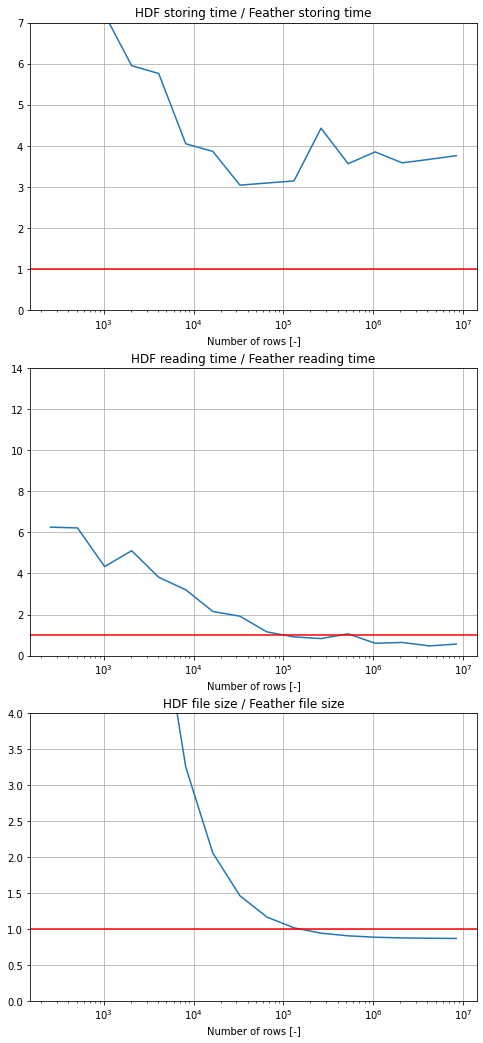

In [20]:
fig, ax = plt.subplots(3,1, figsize=(8,18))
(res['storing_times']['HDF']/res['storing_times']['Feather']).plot(ax=ax[0])
ax[0].set_xscale("log")
ax[0].set_ylim([0,7])
ax[0].grid()
ax[0].set_title('HDF storing time / Feather storing time')
ax[0].set_xlabel('Number of rows [-]')
ax[0].axhline(1.0, color='r')
(res['reading_times']['HDF']/res['reading_times']['Feather']).plot(ax=ax[1])
ax[1].set_xscale("log")
ax[1].set_ylim([0,14])
ax[1].grid()
ax[1].set_title('HDF reading time / Feather reading time')
ax[1].axhline(1.0, color='r')
ax[1].set_xlabel('Number of rows [-]')
(res['sizes']['HDF']/res['sizes']['Feather']).plot(ax=ax[2])
ax[2].set_xscale("log")
ax[2].set_ylim([0,4])
ax[2].grid()
ax[2].set_title('HDF file size / Feather file size')
ax[2].axhline(1.0, color='r')
ax[2].set_xlabel('Number of rows [-]');